# Caso C: Clasificacion de imágenes de rostros de personas con mascarilla y sexo.


# Descripcion 

Debido a la pandemia de COVID 19 el uso de mascarillas se hace indispensable. El propósito de
esta tarea es clasificar imágenes de rostros de personas con mascarillas y sin mascarillas. Además,
el clasificador debe ser capaz de inferir si el rostro corresponde a una persona de sexo masculino o
femenino. La idea es utilizar redes neuronales convolucionales para clasificar 3 experimentos:
* A. Clasificación de personas usando mascarillas
* B. Clasificación del sexo de las personas (independiente si usan o no mascarillas).
* C. Unión de los experimentos A y B en un solo sistema.

# Base de Datos

La base de datos esta compuesta por 5000 imágenes de rostros de personas con y sin mascarillas (2500
imágenes por clase). Por tanto, el número de clases que se tiene en la base de datos es el siguiente:

* Hombre con Mascarilla (1012 imagenes 224x224)
* Hombre sin Mascarilla (1250 imagenes 224x224)
* Mujer con Mascarilla (1488 imagenes 224x224)
* Mujer sin Mascarilla (1250 imagenes 224x224)

Total de Imagenes= 5000 

## link de la base de datos: 
https://drive.google.com/drive/folders/199aiQ55hkxvrc1UvfNKck6Caf4FbRlIE?usp=sharing

#  Importando las imágenes 

En un principio, se deben cargar las librerias necesarias para las distintas etapas del proceso de clasificacion, es decir, librerias para la implementacion de redes neuronales convolucionales, y algunas otras para la etapa de preprocesamiento de las imagenes, entrenamiento de la red y visualizacion de los resultados. 

Ademas, las imagenes de la base de datos estan divididas en carpetas para cada caso de la tarea (Caso A, Caso B y Caso C), y dentro de estas carpetas se encuentran los directorios, en donde a cada uno se le va a asociar un digito o identificador numerico para cada clase, es decir, en el Caso C se tienen 4 carpetas (hombre_mascarilla,hombre_normal,mujer_mascarilla y mujer_normal), por lo tanto, se tienen 4 clases en donde se asigna Clase 0 y Clase 1, Clase 2 y Clase 3. Cada una de estas imagenes tienen un tamaño de 224x224 y un formato jpg. 

In [3]:
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import preprocess_input
from sklearn.model_selection import train_test_split
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D


# parámetros
num_classes = 4 
img_rows, img_cols = 224,224
input_shape = (img_rows, img_cols,3)

# función para cargar las imágenes 

def load_data(path, formato):
    class_names={}
    class_id=0
    Xx = []
    Yy = []
    for d in glob.glob(os.path.join(path, '*')):
        clname = os.path.basename(d)
        for f in glob.glob(os.path.join(d, formato)): 
            if not clname in class_names:
                class_names[clname]=class_id 
                class_id += 1
            img = image.load_img(f, target_size=(img_rows, img_cols))
            npi = image.img_to_array(img)       
            #npi = preprocess_input(npi)
            Xx.append(npi)
            Yy.append(class_names[clname])
    return np.array(Xx), np.array(Yy), class_names


Using TensorFlow backend.


# Descomprimiendo datos (solo si es necesario)

Si desea descomprimir los datos del archivo Dataset.zip, se ejecuta este codigo y se extrae en la ruta definida en zip_ref.extractall('ruta')

In [0]:
#import zipfile
#with zipfile.ZipFile('/content/drive/My Drive/Dataset.zip', 'r') as zip_ref:
    #zip_ref.extractall('')

#  Cargando la base de datos

Los datos se cargan a partir de la funcion creada anteriormente (load_data), en donde se toma como entrada la ruta de la base de datos junto a su nombre y el formato que tiene. Para este caso la base de datos esta compuesta por imagenes en formato jpg. Posteriormente, se realiza un shape en cada uno de los datos para ver la "forma" que tienen estas imagenes, es decir, mostrar cuantas imagenes se tienen, las dimensiones de la imagen y la profundidad de estas. 

In [6]:
# cargar las imágenes, etiquetas y nombres de las clases
Xx, Yy, class_names = load_data('/content/Dataset/exp_C', '*.jpg')

num_classes = len(class_names)

print("Las siguientes imágenes fueron exportadas (ejemplos, fila, col, prof) :")
print(Xx.shape)
print("Las siguientes etiquetas y clases fueron exportadas:")
print(Yy.shape, len(class_names))

Las siguientes imágenes fueron exportadas (ejemplos, fila, col, prof) :
(5000, 224, 224, 3)
Las siguientes etiquetas y clases fueron exportadas:
(5000,) 4


# Revisando las imágenes cargadas

Note que la función plot solo muestra valores entre 0 y 1 adecuadamente. Se observa que la imágen se ve extraña. La razón es la imagen no está en el rango correcto. 

La libreria de Keras tiene una funcion llamada preprocess_input, la cual puede realizar el procedimiento de normalizar una imagen facilmente, por lo que no seria necesario mostrar la etapa que viene a continuacion. Sin embargo, a modo de ejemplo se va a realizar la etapa para mostrar los resultados que se obtienen. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


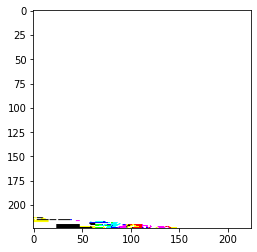

In [7]:
plt.imshow(Xx[0,:,:,:])

In [8]:
i = Xx[0,:,:,:]
print("Valores mínimos y máximos de la imagen")
maxi=(np.max(i))
mini=(np.min(i))
print(mini,maxi )

Valores mínimos y máximos de la imagen
0.0 255.0


Vamos a corregir la imágen con una pequeña normalización de rango (0,1). Ahora la imagen se ve como corresponde.

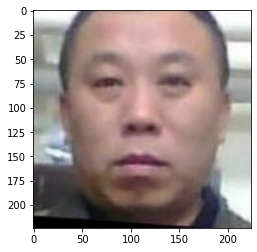

In [9]:
i2 = (i-mini)/(maxi-mini)
plt.imshow(i2)

Creemos una función para mostrar la imagen corregida

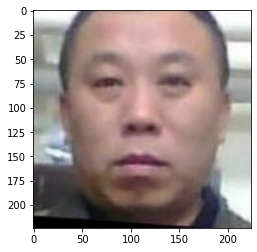

In [10]:
def normalizar_imagen(imagen):
    maxi=(np.max(imagen))
    mini=(np.min(imagen))
    i2 = (imagen-mini)/(maxi-mini)
    plt.imshow(i2)

normalizar_imagen(Xx[0,:,:,:])

#  Dividiendo las imágenes

Una vez se carga la base de datos y se visualizan las imagenes, ya se puede realizar la etapa de division de las imagenes, es decir, formar que porcentaje de datos se ocuparan para el entrenamiento, que porcentaje de datos se ocupara para el test y que porcentaje de datos se ocupara para validar el problema. Para realizar esta division, se necesita utilizar la funcion train_test_split de sklearn, la cual divide entre datos de entrenamiento y test, y luego se realiza una division entre entrenamiento y validacion. Posteriormente, las clases se convierten en datos binarios (0s y 1s) a partir de la funcion to_categorical para que la red neuronal entienda e interprete estos datos.  

In [34]:
x_train, x_test, y_train, y_test = train_test_split(Xx, Yy, test_size=0.1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3)

x_train = x_train.astype('float32')/ 255
x_val = x_val.astype('float32') / 255 
x_test = x_test.astype('float32') /255

print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'val samples')
print(x_test.shape[0], 'test samples')
print(y_train.shape[0], 'train labels')
print(y_val.shape[0], 'val labels')
print(y_test.shape[0], 'test labels')

YY_train=y_train # respaldar variables originales sin hot encoding
YY_val=y_val
YY_test=y_test
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes)
y_val = np_utils.to_categorical(y_val, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

x_train shape: (3150, 224, 224, 3)
x_val shape: (1350, 224, 224, 3)
x_test shape: (500, 224, 224, 3)
3150 train samples
1350 val samples
500 test samples
3150 train labels
1350 val labels
500 test labels


## Se visualiza la primera imagen del conjunto de entrenamiento

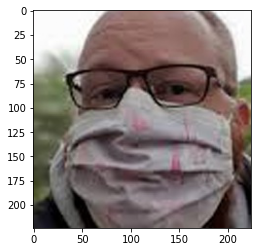

In [35]:
normalizar_imagen(x_train[0])

#  Modelo de CNN

Con los datos divididos y las clases binarizadas, se debe realizar la etapa de creacion del modelo de red neuronal convolucional. En este caso y como se ha visto en las clases, se utilizara el modelo secuencial para construir la red neuronal convolucional, y posteriormente se utiliza la funcion model.summary() para ver el resumen del modelo de CNN creado. 


In [0]:
from keras.layers.normalization import BatchNormalization
# modelo
def modelo_cnn():
    model = Sequential()
    model.add(Conv2D(128, kernel_size=(5, 5),activation='relu',input_shape=input_shape))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Conv2D(32, (3, 3), activation='relu'))
    #model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.30))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = modelo_cnn()

In [37]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 220, 220, 128)     9728      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 110, 110, 128)     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 108, 108, 64)      73792     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 32)       

#  Ajustar la red neuronal convolucional 

Ya con el modelo de la CNN definido, se debe realizar la etapa de entrenamiento de la red neuronal. Esta etapa consiste en prueba/error, por lo que es importante ir variando los parametros como las epocas, el tamaño del lote, etc. Una vez se realiza la etapa de entrenamiento, se visualizan las graficas de las perdidas y la precision del modelo, ademas se entregan los valores numericos de perdida y precision obtenido en el proceso. Es importante que la curva de precision de los datos de entrenamiento sea similar a la curva de precision de los datos de validacion. 

Train on 3150 samples, validate on 1350 samples
Epoch 1/40
3150/3150 [==============================] - 9s 3ms/step - loss: 1.1345 - accuracy: 0.4448 - val_loss: 0.8166 - val_accuracy: 0.5793
Epoch 2/40
3150/3150 [==============================] - 8s 3ms/step - loss: 0.7716 - accuracy: 0.6413 - val_loss: 0.6170 - val_accuracy: 0.7430
Epoch 3/40
3150/3150 [==============================] - 8s 3ms/step - loss: 0.6851 - accuracy: 0.6965 - val_loss: 0.5803 - val_accuracy: 0.7622
Epoch 4/40
3150/3150 [==============================] - 8s 3ms/step - loss: 0.6310 - accuracy: 0.7194 - val_loss: 0.5376 - val_accuracy: 0.7696
Epoch 5/40
3150/3150 [==============================] - 8s 3ms/step - loss: 0.5456 - accuracy: 0.7505 - val_loss: 0.4859 - val_accuracy: 0.7911
Epoch 6/40
3150/3150 [==============================] - 8s 3ms/step - loss: 0.4917 - accuracy: 0.7762 - val_loss: 0.4245 - val_accuracy: 0.8030
Epoch 7/40
3150/3150 [==============================] - 8s 3ms/step - loss: 0.4408 - acc

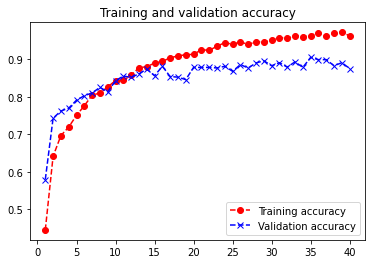

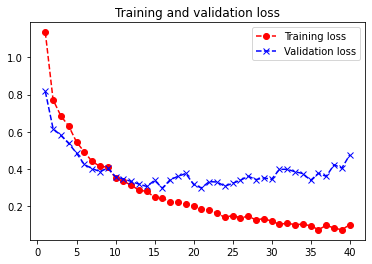

Test loss: 0.38004869174957273
Test accuracy: 0.906000018119812
CNN Error: 9.40%


In [38]:
batch_size = 50
epochs = 40

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_val, y_val))


accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochss = range(1, len(accuracy) + 1)
plt.plot(epochss, accuracy, 'r--o', label='Training accuracy')
plt.plot(epochss, val_accuracy, 'b--x', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochss, loss, 'r--o', label='Training loss')
plt.plot(epochss, val_loss, 'b--x', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("CNN Error: %.2f%%" % (100-score[1]*100))

# Validación de la predicción

Es importante validar el modelo a partir de una prediccion con los datos de test (imagenes que la red neuronal no ha visto) y ver si la red neuronal clasifica de buena forma la imagen. Para realizar esta prediccion se utiliza la funcion model.predict() y para obtener la clase de esa imagen se utiliza la funcion argmax(). 

In [39]:
# para saber el orden de las target_class

print(class_names)

{'hombre_normal': 0, 'mujer_mascarilla': 1, 'mujer_normal': 2, 'hombre_mascarilla': 3}


la imagen de test:
la clase que predice la red es:  Mujer con Mascarilla


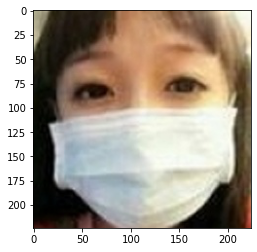

In [114]:
import numpy as np
index = np.random.choice(list(range(len(x_test))), 1)[0]
im = x_test[index]
target_class = {class_names['hombre_normal']:"Hombre sin Mascarilla",class_names['mujer_mascarilla']:"Mujer con Mascarilla",class_names['mujer_normal']:"Mujer sin Mascarilla",class_names['hombre_mascarilla']:"Hombre con Mascarilla"}


print('la imagen de test:')
normalizar_imagen(im)

print('la clase que predice la red es: ', target_class[np.argmax(model.predict(np.reshape(im, [1,img_rows, img_cols,3])), -1)[0]])

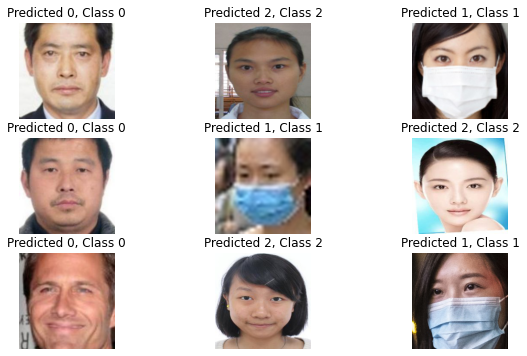

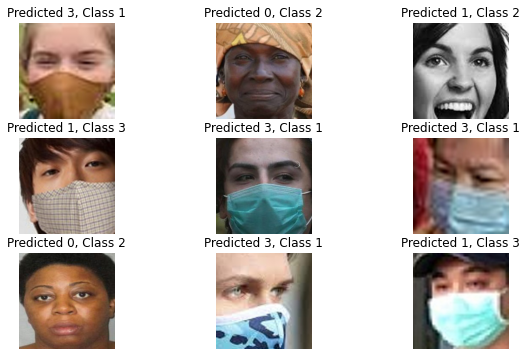

In [41]:
import numpy as np
# predicciones de nuestra CNN con los datos de test
predicted_classes = model.predict_classes(x_test)

# revisemos cuales predicciones son correctas e incorrectas
correct_indices = np.nonzero(predicted_classes == YY_test)[0]
incorrect_indices = np.nonzero(predicted_classes != YY_test)[0]


plt.figure(figsize=(10,6))
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    normalizar_imagen(x_test[correct])
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], YY_test[correct]))
    plt.axis('off')

plt.figure(figsize=(10,6))
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    normalizar_imagen(x_test[incorrect])
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], YY_test[incorrect]))
    plt.axis('off')

# Matriz de confusión y reportes

Una vez se clasifican las imagenes, es importante validarlos a partir de los resultados obtenidos (puntajes) en cada una de las imagenes utilizadas en el set de test. Para este caso, se utilizo el 10% del total de los datos para test, es decir, de 5000 imagenes se ocupan 500 para test. 

Estos parámetros de la matriz de confusión muestran que tan bien se clasifican los datos y la precision final del modelo. 

In [42]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score 

# classification report
print('Reporte de Clasificación:')
print(classification_report( YY_test,predicted_classes))

# confusion matrix 
cm = confusion_matrix(YY_test,predicted_classes)

# mostrar los resultados
print('Matriz de confusión:')
print(cm)

# Print f1, precision, and recall scores
print('Precision:')
print(precision_score(YY_test, predicted_classes , average="macro"))
print('Recall:')
print(recall_score(YY_test, predicted_classes , average="macro"))
print('F1:')
print(f1_score(YY_test, predicted_classes, average="macro"))

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       111
           1       0.95      0.82      0.88       170
           2       0.98      0.95      0.96       130
           3       0.77      0.90      0.83        89

    accuracy                           0.91       500
   macro avg       0.90      0.92      0.90       500
weighted avg       0.91      0.91      0.91       500

Matriz de confusión:
[[110   0   1   0]
 [  5 139   2  24]
 [  5   1 124   0]
 [  2   7   0  80]]
Precision:
0.8982065743853718
Recall:
0.9153401520387641
F1:
0.9037934265512577
